In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchmetrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import random_split

In [2]:
# 設置運行設備 (CUDA 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_properties(device))

    # 清除 CUDA 快取
    torch.cuda.empty_cache()
else:
    print("CUDA is not available. Using CPU.")

NVIDIA GeForce RTX 4070 SUPER
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4070 SUPER', major=8, minor=9, total_memory=12281MB, multi_processor_count=56, uuid=25c21ef8-cd11-c18b-4083-56f7752b9683, L2_cache_size=48MB)


In [3]:
# 圖像預處理（包括調整大小、隨機翻轉、顏色抖動和正規化）
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # 隨機地將圖像水平翻轉，翻轉概率為 50%
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 隨機改變圖像的亮度、對比度、飽和度和色調
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='./miniimagenet', transform=transform)

# 檢視資料集中的類別數量
num_classes = len(train_dataset.classes)

print(f'資料集大小: {len(train_dataset)}')
print(f'資料集中有 {num_classes} 個類別')

資料集大小: 60000
資料集中有 100 個類別


### 將資料集劃分為訓練集和測試集（80% 用於訓練，20% 用於測試）

In [4]:
train_size = int(0.8 * len(train_dataset))
test_size = int(0.2 * len(train_dataset))
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

### 使用 10 way 10 shot 的方式模擬只有少量樣本的情況

In [5]:
import random
from torch.utils.data import Subset

# 隨機從資料集中取樣，返回支援集和查詢集
def sample_n_way_k_shot(dataset, n_way, k_shot, n_query):
    class_to_indices = {class_idx: [] for class_idx in range(num_classes)}
    
    for idx, (image, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    
    # 隨機選擇 N 個類別，並從每個類別中選出 K 張作為支援樣本，選出 n_query 張作為查詢樣本
    selected_classes = random.sample(list(class_to_indices.keys()), n_way)
    
    support_indices = []
    query_indices = []
    
    for class_idx in selected_classes:
        indices = random.sample(class_to_indices[class_idx], k_shot + n_query)
        support_indices.extend(indices[:k_shot])  # 支援樣本
        query_indices.extend(indices[k_shot:])  # 查詢樣本
    
    support_set = Subset(dataset, support_indices)
    query_set = Subset(dataset, query_indices)
    
    return support_set, query_set

### 使用 ResNet50 作為預訓練模型，並只微調最後一層

In [6]:
class CustomResNet50(nn.Module):
    def __init__(self, freeze_pretrained=True):
        super(CustomResNet50, self).__init__()
        self.num_classes = 100
        self.model = models.resnet50(pretrained=True)
        
        if freeze_pretrained:
            for param in self.model.parameters():
                param.requires_grad = False
        # 修改最後的全連接層以適應新類別
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [7]:
# 可視化結果
def plot_loss_acc(train_loss, train_acc, val_loss, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

In [8]:
# 訓練 N-way K-shot 模型的函數
def train_n_way_k_shot(model, n_way, k_shot, n_query, criterion, optimizer, scheduler, epochs):
    # 訓練和驗證準確率的度量器，針對多類別任務進行配置
    train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    
    # 儲存每個 epoch 的訓練和驗證損失與準確率
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()

        # 每個 epoch 從訓練集中隨機抽取支援集和查詢集
        support_set, query_set = sample_n_way_k_shot(train_dataset, n_way, k_shot, n_query)

        # 建立對應的 DataLoader
        support_loader = DataLoader(support_set, batch_size=k_shot * n_way, shuffle=True, num_workers=8)
        query_loader = DataLoader(query_set, batch_size=n_query * n_way, shuffle=True, num_workers=8)

        running_loss = 0.0
        train_accuracy.reset()
        val_accuracy.reset()
        
        # 訓練支援集
        for inputs, labels in support_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # 清空梯度
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 反向傳播
            optimizer.step()  # 更新權重
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_accuracy.update(predicted, labels)

        train_loss = running_loss / len(support_loader)
        train_acc = train_accuracy.compute().cpu().item()
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0

        # 測試查詢集
        with torch.no_grad():
            for inputs, labels in query_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_accuracy.update(predicted, labels)

        val_acc = val_accuracy.compute().cpu().item()
        val_loss /= len(query_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # 根據驗證損失來調整學習率
        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# 測試模型的準確率
def test_model(model, test_loader):
    model.eval()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    accuracy.reset()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            accuracy.update(predicted, labels)

    test_acc = accuracy.compute().cpu().item()

    print(f'Test Accuracy: {100 * test_acc:.4f}%')
    return test_acc

In [9]:
LEARNING_RATE=0.001
EPOCHS=25
N_WAY=10
K_SHOT=10
N_QUERY=20

In [10]:
few_shot_model = CustomResNet50()
few_shot_model = few_shot_model.to(device)

# 損失函數和優化器設置
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(few_shot_model.model.fc.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 開始訓練
train_loss, train_acc, val_loss, val_acc = train_n_way_k_shot(few_shot_model, N_WAY, K_SHOT, N_QUERY, criterion, optimizer, scheduler, epochs=EPOCHS)

c:\Users\wei\Desktop\programs\special topics\mini_image_net\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wei\Desktop\programs\special topics\mini_image_net\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Train Loss: 4.5732, Train Acc: 0.0500, Val Loss: 3.2645, Val Acc: 0.1450
Epoch [2/25], Train Loss: 5.0522, Train Acc: 0.0000, Val Loss: 4.2727, Val Acc: 0.0000
Epoch [3/25], Train Loss: 5.6855, Train Acc: 0.0000, Val Loss: 5.0586, Val Acc: 0.0000
Epoch [4/25], Train Loss: 5.0846, Train Acc: 0.0200, Val Loss: 4.5893, Val Acc: 0.0600
Epoch [5/25], Train Loss: 4.9207, Train Acc: 0.1200, Val Loss: 4.5177, Val Acc: 0.2300
Epoch [6/25], Train Loss: 6.7956, Train Acc: 0.0100, Val Loss: 6.4759, Val Acc: 0.0300
Epoch [7/25], Train Loss: 5.0704, Train Acc: 0.0200, Val Loss: 4.8532, Val Acc: 0.0050
Epoch [8/25], Train Loss: 6.5122, Train Acc: 0.0000, Val Loss: 6.4221, Val Acc: 0.0000
Epoch [9/25], Train Loss: 5.8992, Train Acc: 0.0000, Val Loss: 5.5291, Val Acc: 0.0000
Epoch [10/25], Train Loss: 6.8876, Train Acc: 0.0000, Val Loss: 6.8870, Val Acc: 0.0200
Epoch [11/25], Train Loss: 4.2068, Train Acc: 0.0900, Val Loss: 4.0131, Val Acc: 0.0850
Epoch [12/25], Train Loss: 6.2584, Train 

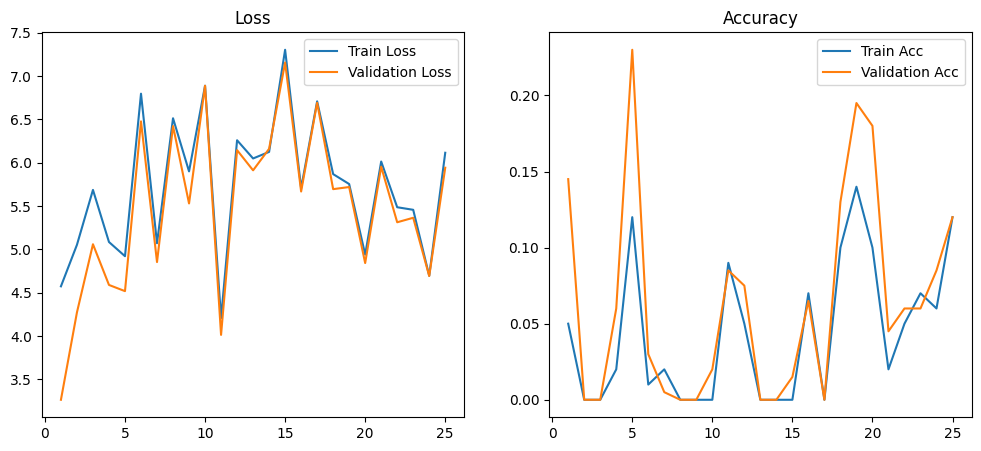

In [11]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc)

In [12]:
test_model(few_shot_model, test_loader)

Test Accuracy: 7.6500%


0.07649999856948853

### 直接使用 80% 資料集做 transfer learning

In [13]:
def train_all_data(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        train_accuracy.reset()
        val_accuracy.reset()

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        
        # 訓練每個批次
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # 清空梯度
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 反向傳播
            optimizer.step()  # 更新權重
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_accuracy.update(predicted, labels)

        # 計算當前 epoch 的平均訓練損失和準確率
        train_loss = running_loss / len(train_loader)
        train_acc = train_accuracy.compute().cpu().item()
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0

        # 禁用梯度計算，進行驗證集測試
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_accuracy.update(predicted, labels)

        val_acc = val_accuracy.compute().cpu().item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # 根據驗證損失調整學習率
        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [14]:
LEARNING_RATE=0.001
EPOCHS=25

In [15]:
# 清空 CUDA 快取，以釋放 GPU 記憶體
torch.cuda.empty_cache()

all_data_model = CustomResNet50()
all_data_model = all_data_model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(all_data_model.model.fc.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 開始訓練
train_loss, train_acc, val_loss, val_acc = train_all_data(all_data_model, train_loader, test_loader, criterion, optimizer, scheduler, EPOCHS)

Epoch 1/25: 100%|██████████| 1500/1500 [01:15<00:00, 19.83it/s]


Epoch [1/25], Train Loss: 0.6220, Train Acc: 0.8473, Val Loss: 0.3068, Val Acc: 0.9142


Epoch 2/25: 100%|██████████| 1500/1500 [01:14<00:00, 20.25it/s]


Epoch [2/25], Train Loss: 0.3735, Train Acc: 0.8941, Val Loss: 0.3703, Val Acc: 0.9012


Epoch 3/25: 100%|██████████| 1500/1500 [01:14<00:00, 20.21it/s]


Epoch [3/25], Train Loss: 0.3565, Train Acc: 0.9002, Val Loss: 0.3528, Val Acc: 0.9090


Epoch 4/25: 100%|██████████| 1500/1500 [01:15<00:00, 19.84it/s]


Epoch [4/25], Train Loss: 0.3375, Train Acc: 0.9072, Val Loss: 0.3682, Val Acc: 0.9089


Epoch 5/25: 100%|██████████| 1500/1500 [01:15<00:00, 19.75it/s]


Epoch [5/25], Train Loss: 0.3309, Train Acc: 0.9088, Val Loss: 0.3778, Val Acc: 0.9068


Epoch 6/25: 100%|██████████| 1500/1500 [01:23<00:00, 17.94it/s]


Epoch [6/25], Train Loss: 0.2417, Train Acc: 0.9290, Val Loss: 0.3249, Val Acc: 0.9190


Epoch 7/25: 100%|██████████| 1500/1500 [03:08<00:00,  7.96it/s]


Epoch [7/25], Train Loss: 0.2332, Train Acc: 0.9297, Val Loss: 0.3228, Val Acc: 0.9207


Epoch 8/25: 100%|██████████| 1500/1500 [03:08<00:00,  7.95it/s]


Epoch [8/25], Train Loss: 0.2291, Train Acc: 0.9304, Val Loss: 0.3244, Val Acc: 0.9210


Epoch 9/25: 100%|██████████| 1500/1500 [03:09<00:00,  7.91it/s]


Epoch [9/25], Train Loss: 0.2114, Train Acc: 0.9359, Val Loss: 0.3317, Val Acc: 0.9154


Epoch 10/25: 100%|██████████| 1500/1500 [02:27<00:00, 10.17it/s]


Epoch [10/25], Train Loss: 0.1781, Train Acc: 0.9438, Val Loss: 0.3015, Val Acc: 0.9208


Epoch 11/25: 100%|██████████| 1500/1500 [03:09<00:00,  7.90it/s]


Epoch [11/25], Train Loss: 0.1777, Train Acc: 0.9444, Val Loss: 0.3019, Val Acc: 0.9239


Epoch 12/25: 100%|██████████| 1500/1500 [03:06<00:00,  8.03it/s]


Epoch [12/25], Train Loss: 0.1727, Train Acc: 0.9448, Val Loss: 0.2956, Val Acc: 0.9237


Epoch 13/25: 100%|██████████| 1500/1500 [03:09<00:00,  7.92it/s]


Epoch [13/25], Train Loss: 0.1703, Train Acc: 0.9449, Val Loss: 0.2964, Val Acc: 0.9217


Epoch 14/25: 100%|██████████| 1500/1500 [03:06<00:00,  8.05it/s]


Epoch [14/25], Train Loss: 0.1654, Train Acc: 0.9469, Val Loss: 0.2951, Val Acc: 0.9225


Epoch 15/25: 100%|██████████| 1500/1500 [02:43<00:00,  9.18it/s]


Epoch [15/25], Train Loss: 0.1661, Train Acc: 0.9467, Val Loss: 0.3088, Val Acc: 0.9217


Epoch 16/25: 100%|██████████| 1500/1500 [01:17<00:00, 19.29it/s]


Epoch [16/25], Train Loss: 0.1664, Train Acc: 0.9462, Val Loss: 0.2990, Val Acc: 0.9234


Epoch 17/25: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s]


Epoch [17/25], Train Loss: 0.1611, Train Acc: 0.9481, Val Loss: 0.3005, Val Acc: 0.9218


Epoch 18/25: 100%|██████████| 1500/1500 [01:17<00:00, 19.25it/s]


Epoch [18/25], Train Loss: 0.1572, Train Acc: 0.9489, Val Loss: 0.2943, Val Acc: 0.9232


Epoch 19/25: 100%|██████████| 1500/1500 [01:16<00:00, 19.50it/s]


Epoch [19/25], Train Loss: 0.1580, Train Acc: 0.9493, Val Loss: 0.2883, Val Acc: 0.9260


Epoch 20/25: 100%|██████████| 1500/1500 [01:17<00:00, 19.48it/s]


Epoch [20/25], Train Loss: 0.1585, Train Acc: 0.9488, Val Loss: 0.2944, Val Acc: 0.9252


Epoch 21/25: 100%|██████████| 1500/1500 [01:17<00:00, 19.39it/s]


Epoch [21/25], Train Loss: 0.1541, Train Acc: 0.9503, Val Loss: 0.2964, Val Acc: 0.9243


Epoch 22/25: 100%|██████████| 1500/1500 [01:17<00:00, 19.36it/s]


Epoch [22/25], Train Loss: 0.1510, Train Acc: 0.9507, Val Loss: 0.3042, Val Acc: 0.9215


Epoch 23/25: 100%|██████████| 1500/1500 [01:17<00:00, 19.31it/s]


Epoch [23/25], Train Loss: 0.1533, Train Acc: 0.9505, Val Loss: 0.3023, Val Acc: 0.9212


Epoch 24/25: 100%|██████████| 1500/1500 [01:18<00:00, 19.21it/s]


Epoch [24/25], Train Loss: 0.1358, Train Acc: 0.9558, Val Loss: 0.2774, Val Acc: 0.9274


Epoch 25/25: 100%|██████████| 1500/1500 [01:18<00:00, 19.16it/s]


Epoch [25/25], Train Loss: 0.1355, Train Acc: 0.9554, Val Loss: 0.2921, Val Acc: 0.9245


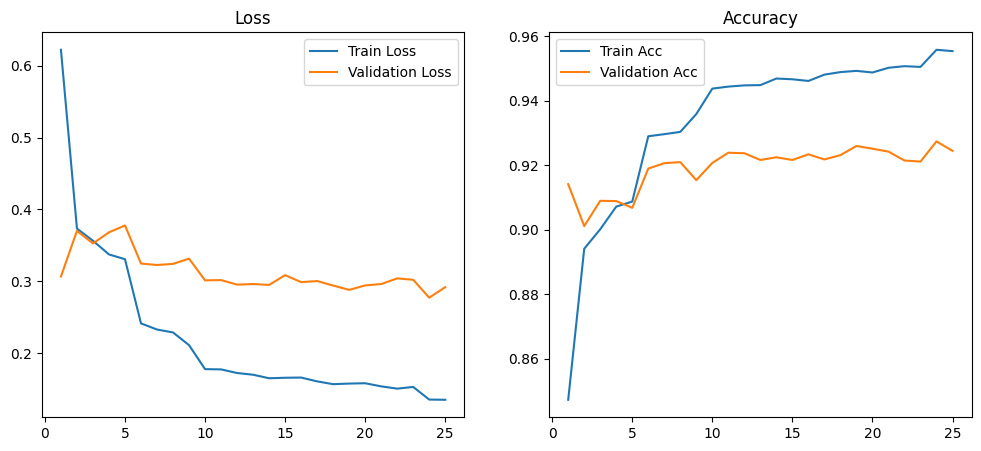

In [16]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc)

In [17]:
test_model(all_data_model, test_loader)

Test Accuracy: 92.6250%


0.9262499809265137

### 報告
- 使用 10 way 10 shot 的方式模擬只有少量樣本的情況 : 模型只有 5% 左右的準確率，這表明當支援集中的樣本數量非常少時，模型可能無法學到足夠的區分特徵。

- 直接使用 80% 資料集做 transfer learning : 模型可以達到90%以上的準確率，訓練集中有更多樣的樣本，這讓模型能夠學習到更多樣的類別特徵，並且更好地識別不同類別之間的區別。